In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings

import pickle

warnings.filterwarnings('ignore')

In [2]:
train_path = 'data/train_data.csv' # Already with target in it
test_path = 'data/test_data.csv'
sample_path = 'data/sample_submission.csv'

In [3]:
train_data = pd.read_csv(train_path).set_index('customer_ID')
test_data = pd.read_csv(test_path).set_index('customer_ID')
sample_data = pd.read_csv(sample_path)

print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')

Train shape: (458913, 190)
Test shape: (924621, 189)


# Feature Engineering

## Dealing with missing values and high correlation
Variables >= 80% of missing values will be removed, and the rest will have imputation.

In [4]:
var_null = [c for c in train_data.columns if (train_data[c].isnull().sum()/train_data.shape[0]) >= 0.8]
print(len(var_null))

for v in var_null:
    print(v, end=' ')

23
D_42 D_49 D_66 D_73 D_76 R_9 B_29 D_87 D_88 D_106 R_26 D_108 D_110 D_111 B_39 B_42 D_132 D_134 D_135 D_136 D_137 D_138 D_142 

In [143]:
corr = train_data.corr()
drop_corr = []

for i in range(len(corr.columns) - 1):
   if corr.columns[i] in drop_corr:
      continue

   for j in range(i+1, len(corr.columns)):
      if abs(corr.iloc[i,j]) > 0.9 and corr.columns[j] not in drop_corr:
         drop_corr.append(corr.columns[j])

In [144]:
to_drop = var_null + drop_corr
print(len(to_drop))

39


In [145]:
train_data.drop(to_drop, axis=1, inplace=True)
test_data.drop(to_drop, axis=1, inplace=True)

print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')

Train shape: (458913, 152)
Test shape: (924621, 151)


In [97]:
del to_drop, var_null, drop_corr

## Undersample data for a balanced dataset

In [157]:
pay = train_data[train_data['target']==0]
default = train_data[train_data['target']==1]

print(f'Payable shape: {pay.shape}, and default shape: {default.shape}')

Payable shape: (340085, 152), and default shape: (118828, 152)


In [158]:
pay = pay.head(len(pay)*3//4)

print(f'Payable shape: {pay.shape}, and default shape: {default.shape}')

Payable shape: (255063, 152), and default shape: (118828, 152)


In [159]:
train_data2 = pd.concat([pay, default]).sort_values(by='S_2')

print(train_data2.shape)
train_data2['target'].value_counts()

del pay, default, train_data

(373891, 152)


0    255063
1    118828
Name: target, dtype: int64

## Label encoder for categorical features

In [8]:
from sklearn.preprocessing import LabelEncoder

def remove_or_label(table: pd.DataFrame, method: str) -> pd.DataFrame:
    '''Remove or encode categorical features of a DataFrame.'''
    cat_feat = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

    if method=='label_encoder':
        le = LabelEncoder()
        for feat in cat_feat:
            if feat in table.columns:
                table[feat] = le.fit_transform(table[feat])
    
    elif method=='remove':
        for feat in cat_feat:
            if feat in table.columns:
                table.drop(feat, axis=1, inplace=True)
    
    return table

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [6]:
X = train_data.drop(['target', 'S_2'], axis=1)
y = train_data['target']

In [5]:
imp = SimpleImputer(strategy='mean')
# scaler = StandardScaler()
# pca = PCA(n_components=108, random_state=42)

In [8]:
X_imputed = imp.fit_transform(X.values)
# X_scaled = scaler.fit_transform(X_imputed)

# pca.fit(X_scaled)

# X_pca = pca.transform(X_scaled)

In [ ]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
# plt.xlabel('Number of components')
# plt.ylabel('Explained variance');

In [ ]:
# var_ex_ratio = np.cumsum(pca.explained_variance_ratio_*100)

# for ver in range(0, len(var_ex_ratio), 2):
#     print(f'Variance explained by the first {ver} principal components = {round(var_ex_ratio[ver], 2)}%')

## Train Test Split and oversampling dataset

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# X_ovr, y_ovr = BorderlineSMOTE(random_state=42).fit_resample(X_train, y_train)
# print(f'X shape: {X_ovr.shape}')
# print(f'y shape: {y_ovr.shape}')
# print(y_ovr.value_counts())

X_train = X_train.round(decimals=2)
X_test = X_test.round(decimals=2)

del X, y, X_imputed, # var_ex_ratio, X_pca, X_scaled

# Model

In [10]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [11]:
xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eval_metric': ['auc', 'binary_logloss']
        }



xgb = XGBClassifier(learning_rate=0.02, n_estimators=600,
        objective='binary:logistic', nthread=1)

In [12]:
random_search = RandomizedSearchCV(
    xgb, param_distributions=xgb_params, n_iter=5,
    scoring='roc_auc',
    n_jobs=-2, cv=3,
    verbose=3,
    random_state=42
)

In [13]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[17:44:31] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:44:31] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:44:31] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost 

KeyboardInterrupt: 

In [38]:
xgbc = XGBClassifier(n_jobs=-2)
xgbc.fit(
    X_ovr, y_ovr
    )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-2, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [39]:
xgbc_pred = xgbc.predict(X_test)

In [40]:
print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     68017
           1       0.78      0.83      0.81     23766

    accuracy                           0.90     91783
   macro avg       0.86      0.88      0.87     91783
weighted avg       0.90      0.90      0.90     91783



In [10]:
#Reference of these params took from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
params = {'boosting_type': 'gbdt',
          'n_estimators': 1000,
          'num_leaves': 50,
          'learning_rate': 0.05,
          'colsample_bytree': 0.9,
          'min_child_samples': 2000,
          'max_bins': 500,
          'reg_alpha': 2,
          'objective': 'binary',
          'random_state': 21}

model = LGBMClassifier(**params)

In [11]:
model.fit(
    X_ovr, y_ovr,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[early_stopping(100), log_evaluation(200)],
    eval_metric=['auc, binary_logloss']
)

[LightGBM] [Warning] Unknown parameter: binary_logloss,binary
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.96111	valid_1's auc: 0.95899
[400]	valid_0's auc: 0.965438	valid_1's auc: 0.960514
[600]	valid_0's auc: 0.967818	valid_1's auc: 0.960837
[800]	valid_0's auc: 0.969703	valid_1's auc: 0.960947
[1000]	valid_0's auc: 0.971337	valid_1's auc: 0.960989
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.971337	valid_1's auc: 0.960989


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, max_bins=500,
               min_child_samples=2000, n_estimators=1000, num_leaves=50,
               objective='binary', random_state=21, reg_alpha=2)

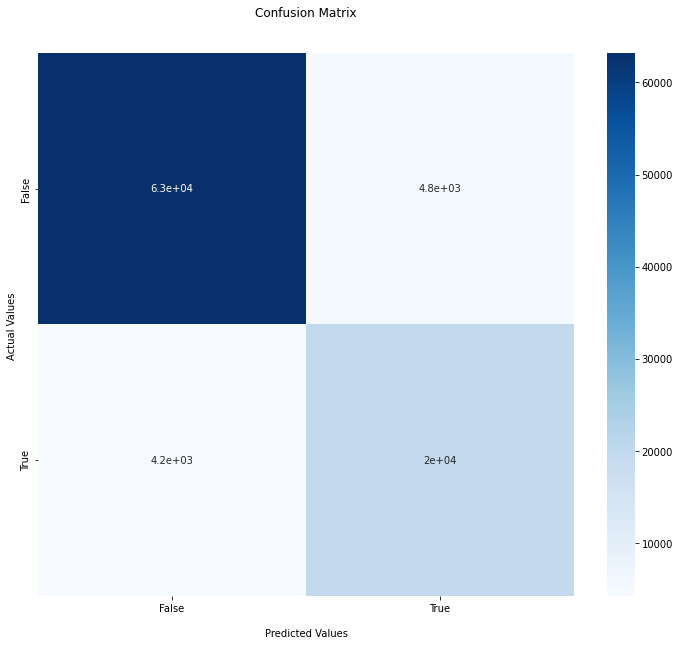

In [12]:
y_pred = model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(12,10))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     68017
           1       0.80      0.82      0.81     23766

    accuracy                           0.90     91783
   macro avg       0.87      0.88      0.87     91783
weighted avg       0.90      0.90      0.90     91783



## Export model

In [23]:
with open('models/model_4.pkl', 'wb') as out:
    pickle.dump(model, out)

## Import model

In [6]:
with open('models/model_4.pkl', 'rb') as entry:
    imp_model = pickle.load(entry)

In [9]:
test_data = remove_or_label(test_data, 'label_encoder')

In [11]:
test_imputed = imp.fit_transform(test_data.drop('S_2', axis=1))

In [ ]:
# test_scaled = scaler.fit_transform(test_imputed)
# test_pca = pca.fit_transform(test_scaled)

In [12]:
test_pred = imp_model.predict_proba(test_imputed)

In [13]:
sample_data['prediction'] = test_pred[:, 1]

sample_data.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.751350
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.808321
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.741346
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.955466
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.994442


In [14]:
sample_data.to_csv('submission.csv',index=False)